# Figure 1 from Sex-biased gene expression and alternative splicing. 

This notebook demonstrates how the results presented in Figure 1 of the manuscript were generated. Two of the five panels of Figure 1 are
generated by this script, panels (c) and (e).

## **Running this notebook**:

A few steps are needed before you can run this document on your own. The GitHub repository (https://github.com/TheJacksonLaboratory/sbas) of the project contains detailed instructions for setting up the environment in the **`dependencies/README.md`** document. Before starting with the analysis, make sure you have first completed the dependencies set up by following the instructions described there. If you have not done this already, you will need to close and restart this notebook before running it.

All paths defined in this Notebook are relative to the parent directory (repository). 

# 1. Setup
## 1.1 Loading dependencies

In [1]:
library(downloader)
library(readr)
library(edgeR)
library(biomaRt)
library(DBI) # v >= 1.1.0 required for biomaRt
library(devtools)
library(yarn)
library(statmod)
library(piggyback)
library(snakecase)
library(stringr)
library(pheatmap)
library(magrittr)
library(dplyr)
library(ggplot2)
library(scales)
library(viridis)
library(scales)

Sys.setenv(TAR = "/bin/tar") # for gzfile

Warning message:
“package ‘downloader’ was built under R version 3.6.3”Warning message:
“package ‘readr’ was built under R version 3.6.3”Loading required package: limma
Warning message:
“package ‘DBI’ was built under R version 3.6.3”Loading required package: Biobase
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following object is masked from ‘package:limma’:

    plotMA

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lappl

## Figure 1c  Heatplot representing similarity in the fold-changes between male and female samples
First, we will generate Figure 1c. The values in the heatmap represent the correlation (similarity in the fold-changes) between male and female samples, with the values in the heatmap being the correlation between the vectors of fold changes of the tissues.

## 1.2 Retrieving the GTEx archive

We used the R package [yarn](https://bioconductor.org/packages/release/bioc/html/yarn.html) to retrieve the GTEx Biobank data. In order to download the latest GTEx version (8.0) for RNA-seq and genotype data (phs000424.v8.v2), released 2019-08-26, we created a fork of the package's GitHub repository and created a new version of the function **`yarn::downloadGTEx()`**, namely **`yarn::downloadGTExV8()`** to download this release. 

We used the function to perform quality control, gene filtering and normalization pre-processing on the GTEx RNA-seq data. This pipeline tested for sample sex-misidentification, merged related sub-tissues and performed tissue-aware normalization using the **`{yarn::qsmooth}`**  function ([Paulson et al, 2017](https://pubmed.ncbi.nlm.nih.gov/28974199/)).

We have archived the output of the **`yarn::downloadGTExV8()`** function, which is an `ExpressionSet` object in the repo `lifebitai/lifebitCloudOSDREgtex` for replicability and decreasing the runtime of this analysis. Below we retrieve this `gtex.rds` object from the GitHub releases using the **`{ropensci/piggyback}`** package, but we have also added the relevant command to retrieve the data from GTEx and generate the `ExpressionSet` object using  **`yarn::downloadGTExV8()`**. For the current analysis we are utilising a compute resource with 8 vCPUs and 60 GB of memory available.

You need to set your github token
Sys.setenv(GITHUB_TOKEN = "your-very-own-github-token")


In [2]:
#Sys.setenv(GITHUB_TOKEN = "your-very-own-github-token")


Did you remember to remove the token

## Download with yarn, if the data are not already in your repository


In [3]:
# Download with yarn if you wish, this requires several minutes to complete
if (!("gtex.rds" %in% list.files("../data/"))) {
    message("Downloading GTEx v8 with 'yarn::downloadGTExV8()'")
    obj <- yarn::downloadGTExV8(type='genes',file='../data/gtex.rds')
    message("Done!")

} else {
# Load with readRDS() if gtex.rds available in data/
    message("Loading GTEx v8 rds object with readRDS from ../data/gtex.rds ..\n")   
    obj <- readRDS(file = "../data/gtex.rds")
    message("Done!\n")
    message("Generating sha256sum for gtex.rds ..\n")    
    message(system("sha256sum ../data/gtex.rds", intern = TRUE))
    message("Done!\n")
} 
# Confirm that it is an expression set.
# and check the dimensions of the objects, and the phenotype information of the objects
class(obj) 
dim(phenoData(obj))
dim(obj)

Loading GTEx v8 rds object with readRDS from ../data/gtex.rds ..

Done!

Generating sha256sum for gtex.rds ..

c3c81a2b5b1f17811d2ab828edf1d4c65e8e4a6632964db73555c4b5737fadf0  ../data/gtex.rds
Done!



[1] "ExpressionSet"
attr(,"package")
[1] "Biobase"

rowNames columnNames 
      17384          67

Features  Samples 
   55878    17382

## 1.3 download the Annotation file saved from getting the GTEx Fastq's

This is the annotation file as organized by dbGaP, we use yarn as the annotations for sex have been noted to be incorrect.
This file and the object from yarn will be joined in this way the differences can be noted, and managed.

In [4]:
# If the SraRunTable from SRA's dbGaP not already in our directories, download with SraRunTable.noCram.noExome.noWGS.totalRNA.txt.gz 
# the annotations in this file have errors -- so for the samples we will use the yarn annotations
if (!("SraRunTable.txt.gz" %in% list.files("../data/"))) {
    piggyback::pb_download(
        repo = "TheJacksonLaboratory/sbas", 
        file = "SraRunTable.txt.gz",
        tag  = "GTExV8.v1.0", 
        dest = "../data/")
    metadata          <- data.table::fread("../data/SraRunTable.txt.gz")
} else {
    metadata          <- data.table::fread("../data/SraRunTable.txt.gz")
    
}

## 1.4: Quality control, preprocessing of data 

We observed above that our phenotype data have 2 more observations than our expression data. Let's inspect what these samples are:

In [5]:
sample_names=as.vector(as.character(colnames(exprs(obj))))
pheno_sample_names=as.vector(as.character(rownames(pData(obj))))
length(pheno_sample_names)
length(sample_names)

if (length(pheno_sample_names) > length(sample_names)) {
    superset <- pheno_sample_names
    subset   <- sample_names    
} 

if (length(pheno_sample_names) < length(sample_names)) {
    superset <- sample_names
    subset   <- pheno_sample_names   
} 

non_overlaps <- setdiff( superset, subset)

message("The non-overlapping IDs between pheno and count data are:\n\n", 
        paste(non_overlaps, collapse = "\n") )
logical_match_names=superset %in% subset
length(logical_match_names)
table(logical_match_names)
pData(obj) <- (pData(obj)[logical_match_names==TRUE,])
dim(pData(obj))
dim(obj)

[1] 17384

[1] 17382

The non-overlapping IDs between pheno and count data are:

GTEX-YF7O-2326-101833-SM-5CVN9
GTEX-YEC3-1426-101806-SM-5PNXX


[1] 17384

logical_match_names
FALSE  TRUE 
    2 17382 

[1] 17382    67

Features  Samples 
   55878    17382

### 1.4.2   Replace all *dashes* with **dots "."**

In [6]:
pData(obj)$SAMPID[1]
pData(obj)$SAMPID <- gsub('-','\\.',pData(obj)$SAMPID)
pData(obj)$SAMPID[1]

GTEX-1117F-0226-SM-5GZZ7 
GTEX-1117F-0226-SM-5GZZ7 
22951 Levels: GTEX-1117F-0003-SM-58Q7G ... K-562-SM-E9EZZ

[1] "GTEX.1117F.0226.SM.5GZZ7"

### 1.4.3   Synchronize Clinical Annotations and Accession Run, reducing to only tissues of interest

Join the yarn metadata with the metadata we have (there are redundant samples that have been sequenced multiple times). We want to be sure that we can obtain all required Clinical Annotation information from the YARN GTEx Annotation information, as the SRA metadata is not as reliable.    This will be a one-to-many mapping, as there are multiple sequence runs per 69 samples -- expanding our data set.  There are only a handful of annotations we require: SEX, AGE, DTHHRDY (which is cause of death), SMCENTER.

Note that the numbers in specific age groups expand because of the one to many relationship from sample to sequencing runs. 

#### Using results from analysis of number of samples stored in `tissues.tsv` we keep only those that are members of this reduced tissue list.

In [7]:
# read in all requirements so that the stage is properly set -- 
# if it is clear here -- it will remain clear for the rest of the time
# tissues.tsv contains the subset of files desired for analysis.
tissue_reduction <- read.table(file="../assets/tissues.tsv", header=TRUE, sep="\t",
                               skipNul=FALSE, stringsAsFactors = FALSE)
colnames(tissue_reduction)  <- c("SMTSD","female","male","include","display_name")

message("\nsize tissue_reduction\n",
        paste(dim(tissue_reduction), collapse=" "))
message("\nsize obj\n",
        paste(dim(obj)), collapse="\n")
message("\nsize pData(obj)\n",
        paste(dim(pData(obj)), collapse=" "))

# only include those tissues we wish to continue with
table(tissue_reduction$include)
tissue_reduction <- tissue_reduction[tissue_reduction$include==1,]

# create a matching tissue name to go with the expressionSet phenotype object
pData(obj)$SMTSD       <- factor(snakecase::to_snake_case(as.character(pData(obj)$SMTSD)))
tissue_reduction$SMTSD <- factor(snakecase::to_snake_case(as.character(tissue_reduction$SMTSD)))

message("\nlength tissues in phenotype data\n",
        paste(length(levels(pData(obj)$SMTSD)), collapse = " "))
message("\nlength tissues in tissue_reduction data\n",
        paste(length(tissue_reduction$SMTSD), collapse = " "))

keep <- pData(obj)$SMTSD %in% tissue_reduction$SMTSD
message("\nlength tissue in samples phenotype data\n",
        paste(length(pData(obj)$SMTSD), collapse = " "))
message("\nlength keep obj \n",
        paste(length(keep), collapse = " "))
message("\nhow many to keep in phenotype data\n",
        paste(table(keep), collapse = " "))

# both obj and pData(obj) need to be adjusted
reduced_obj        <- obj       [          ,keep==TRUE]
pData(reduced_obj) <- pData(obj)[keep==TRUE,          ]
rm(keep)
message("\nsize reduced_obj\n",
        paste(dim(reduced_obj)), collapse=" ")
message("\nsize pData(reduced_obj)\n",
        paste(dim(pData(reduced_obj)), collapse=" "))
message("\nlength tissues in phenotype data\n",
        paste(length(levels(pData(reduced_obj)$SMTSD)), collapse = " "))

# test to make sure we don't have nonsense
keep = pData(reduced_obj)$SMTSD== "breast_mammary_tissue"
message("\nTEST: how many to keep in to have only breast_mammary_tissue\n",
        paste(table(keep), collapse = " "))
tobj        = reduced_obj       [          ,keep==TRUE]
pData(tobj) = pData(reduced_obj)[keep==TRUE,          ]
message("\nTEST: size breast_mammary_tissue obj:tobj\n",
        paste(dim(tobj), collapse=" "))
message("\nTEST: size phenotype object pData(tobj)\n",
        paste(dim(pData(tobj)), collapse=" "))
pData(tobj)[1,]
rm(keep)
# end test


size tissue_reduction
50 5

size obj
5587817382


size pData(obj)
17382 67



 0  1 
11 39 


length tissues in phenotype data
54

length tissues in tissue_reduction data
39

length tissue in samples phenotype data
17382

length keep obj 
17382

how many to keep in phenotype data
1851 15531

size reduced_obj
5587815531 

size pData(reduced_obj)
15531 67

length tissues in phenotype data
54

TEST: how many to keep in to have only breast_mammary_tissue
15072 459

TEST: size breast_mammary_tissue obj:tobj
55878 459

TEST: size phenotype object pData(tobj)
459 67


,SAMPID,SMATSSCR,SMCENTER,SMPTHNTS,SMRIN,SMTS,SMTSD,SMUBRID,SMTSISCH,SMTSPAX,⋯,SME1PCTS,SMRRNART,SME1MPRT,SMNUM5CD,SMDPMPRT,SME2PCTS,SUBJID,SEX,AGE,DTHHRDY
,<chr>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,⋯,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>
GTEX-1117F-2826-SM-5GZXL,GTEX.1117F.2826.SM.5GZXL,1,B1,"2 pieces, fibrocystic changes, rep ductal/lobular elements delineated",5.80000,Breast,breast_mammary_tissue,0008367,1340,1008,⋯,50.2455,0.015023200,0.9943150,NA,0,50.0068,GTEX-1117F,2,60-69,4


#### Synchronize accession metadata and phenotype data
A kind of transitive closure.   Metadata links the count data to the phenotype data.
Begin with synchronizing accession metadata and phenotype data - which has been reduced - `reduced_obj` inputs here 

In [8]:
# let's limit the phenotype object and then align the metadata file
# input assumption is expressionSet object is now `reduced_obj`
metadata <- data.table::fread("../data/SraRunTable.txt.gz")
metadata$SAMPID           <- gsub('-','\\.',metadata$'Sample Name')
pData(reduced_obj)$SAMPID <- gsub('-','\\.',pData(reduced_obj)$SAMPID)

message("\nsize accession SraRunTable \n",
        paste(dim(metadata), collapse=" "))
message("\nsize reduced_obj\n",
        paste(dim(reduced_obj), collapse=" "))
message("\nsize pData(reduced_obj)\n",
        paste(dim(pData(reduced_obj)), collapse=" "))
rownames(pData(reduced_obj))<- pData(reduced_obj)$SAMPID

# keep only those runs (as epitomized by the metadata_samples) in the phenotype set
metadata_samples   <- as.character(metadata$SAMPID)
phenotype_samples  <- as.character(pData(reduced_obj)$SAMPID)

# any undefined (N/A) sample names? These results will be zero
message("\n any undefined (NA) sample names?\n",
        paste(sum(is.na(metadata_samples)), collapse=" "))
message("\n any undefined (NA) sample names?\n",
        paste(sum(is.na(phenotype_samples)), collapse=" "))

keep <- phenotype_samples %in% metadata_samples
message("\nlength keep metadata samples in phenotype samples \n",
        paste(length(keep), collapse = " "))
message("\nhow many to keep in phenotype obj\n",
        paste(table(keep), collapse = " "))

reduced_obj2        <- reduced_obj       [          ,keep==TRUE]
pData(reduced_obj2) <- pData(reduced_obj)[keep==TRUE,          ]
message("\nsize reduced_obj2\n",
        paste(dim(reduced_obj2), collapse=" "))
message("\nsize pData(reduced_obj2)\n",
        paste(dim(pData(reduced_obj2)), collapse=" "))

# test to make sure we don't have nonsense
keep = pData(reduced_obj2)$SMTSD == "breast_mammary_tissue"
message("\nTEST: how many to keep in to have only breast_mammary_tissue\n",
        paste(table(keep), collapse = " "))
tobj        = reduced_obj2       [          ,keep==TRUE]
pData(tobj) = pData(reduced_obj2)[keep==TRUE,          ]
message("\nTEST: size breast_mammary_tissue obj:tobj\n",
        paste(dim(tobj), collapse=" "))
message("\nTEST: size phenotype object pData(tobj)\n",
        paste(dim(pData(tobj)), collapse=" "))
pData(tobj)[1,]
rm(keep)
# end test

# now go the other way - make sure the metadata samples are in sync with the phenotype samples
# note that we are now with `reduced_obj2`
metadata_samples   <- as.character(metadata$SAMPID)
phenotype_samples  <- as.character(pData(reduced_obj2)$SAMPID)
message("\nlength of metadata_samples\n",
        paste(length(metadata_samples), collapse=" "))
message("\nlength of phenotype_samples\n",
        paste(length(phenotype_samples), collapse=" "))
message("\ndimension of metadata\n",
        paste(dim(metadata), collapse=" "))
keep <- metadata_samples %in% phenotype_samples
message("\nlength keep phenotype samples in metadata samples \n",
        paste(length(keep), collapse = " "))
message("\nhow many to keep in metadata samples\n")

reduced_metadata <- metadata[keep==TRUE,]
message("\ndimension of reduced_metadata\n",
        paste(dim(reduced_metadata), collapse=" "))
rm(keep)

# test to make sure we don't have nonsense
keep = pData(reduced_obj2)$SMTSD== "breast_mammary_tissue"
message("\nTEST: how many to keep in to have only breast_mammary_tissue\n",
        paste(table(keep), collapse = " "))
tobj        = reduced_obj2       [          ,keep==TRUE]
pData(tobj) = pData(reduced_obj2)[keep==TRUE,          ]
message("\nTEST: size breast_mammary_tissue obj:tobj\n",
        paste(dim(tobj), collapse=" "))
message("\nTEST: size phenotype object pData(tobj)\n",
        paste(dim(pData(tobj)), collapse=" "))
pData(tobj)[1,]
rm(keep)

breast_metadata_samples   <- as.character(reduced_metadata$SAMPID)
breast_phenotype_samples  <- as.character(pData(tobj)$SAMPID)
keep = breast_metadata_samples %in% breast_phenotype_samples
table(keep)
message("\nTEST: how many breast_mammary_tissue samples in reduced_metadata\n",
        paste(table(keep), collapse = " "))
breast_samples <- reduced_metadata[keep,]
message("\nTEST: number reduced_metadata breast_samples\n",
        paste(length(breast_samples$SAMPID), collapse=" "))
message("\nTEST: number phenotype obj breast_samples\n",
        paste(length(pData(tobj)$SAMPID), collapse=" "))
breast_samples[1,]
# end test



size accession SraRunTable 
24667 80

size reduced_obj
55878 15531

size pData(reduced_obj)
15531 67

 any undefined (NA) sample names?
0

 any undefined (NA) sample names?
0

length keep metadata samples in phenotype samples 
15531

how many to keep in phenotype obj
5159 10372

size reduced_obj2
55878 10372

size pData(reduced_obj2)
10372 67

TEST: how many to keep in to have only breast_mammary_tissue
10086 286

TEST: size breast_mammary_tissue obj:tobj
55878 286

TEST: size phenotype object pData(tobj)
286 67


,SAMPID,SMATSSCR,SMCENTER,SMPTHNTS,SMRIN,SMTS,SMTSD,SMUBRID,SMTSISCH,SMTSPAX,⋯,SME1PCTS,SMRRNART,SME1MPRT,SMNUM5CD,SMDPMPRT,SME2PCTS,SUBJID,SEX,AGE,DTHHRDY
,<chr>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,⋯,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>
GTEX.1117F.2826.SM.5GZXL,GTEX.1117F.2826.SM.5GZXL,1,B1,"2 pieces, fibrocystic changes, rep ductal/lobular elements delineated",5.80000,Breast,breast_mammary_tissue,0008367,1340,1008,⋯,50.2455,0.015023200,0.9943150,NA,0,50.0068,GTEX-1117F,2,60-69,4



length of metadata_samples
24667

length of phenotype_samples
10372

dimension of metadata
24667 80

length keep phenotype samples in metadata samples 
24667

how many to keep in metadata samples


dimension of reduced_metadata
18214 80

TEST: how many to keep in to have only breast_mammary_tissue
10086 286

TEST: size breast_mammary_tissue obj:tobj
55878 286

TEST: size phenotype object pData(tobj)
286 67


,SAMPID,SMATSSCR,SMCENTER,SMPTHNTS,SMRIN,SMTS,SMTSD,SMUBRID,SMTSISCH,SMTSPAX,⋯,SME1PCTS,SMRRNART,SME1MPRT,SMNUM5CD,SMDPMPRT,SME2PCTS,SUBJID,SEX,AGE,DTHHRDY
,<chr>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,⋯,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>
GTEX.1117F.2826.SM.5GZXL,GTEX.1117F.2826.SM.5GZXL,1,B1,"2 pieces, fibrocystic changes, rep ductal/lobular elements delineated",5.80000,Breast,breast_mammary_tissue,0008367,1340,1008,⋯,50.2455,0.015023200,0.9943150,NA,0,50.0068,GTEX-1117F,2,60-69,4


keep
FALSE  TRUE 
17722   492 


TEST: how many breast_mammary_tissue samples in reduced_metadata
17722 492

TEST: number reduced_metadata breast_samples
492

TEST: number phenotype obj breast_samples
286


Run,analyte_type,Assay Type,AvgSpotLen,Bases,BioProject,BioSample,biospecimen_repository,biospecimen_repository_sample_id,body_site,⋯,product_part_number (exp),product_part_number (run),sample_barcode (exp),sample_barcode (run),is_technical_control,target_set (exp),primary_disease (exp),secondary_accessions (run),Alignment_Provider (run),SAMPID
<chr>,<chr>,<chr>,<int>,<int64>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
SRR821498,RNA:Total RNA,RNA-Seq,152,7879119272,PRJNA75899,SAMN01994192,GTEx,GTEX-WI4N-1426-SM-3LK7H,Breast - Mammary Tissue,⋯,,,NA,NA,,,,,,GTEX.WI4N.1426.SM.3LK7H


# 2.  Differential Expression using `edgeR`

##  2.1  For each tissue, model gene expression by tissue

Differential Analysis (DE) was performed using voom (Law et.al., 2014) with gene expression counts with associated precision weights, followed by linear modeling and empirical Bayes procedure using limma. 

Within each tissue, the following linear regression model was used to detec secually dimorphic alternative splicing event expression:


           y = B0 + B1 sex + epsilon (error)
           

where y is the gene expression to be modeled sex denotes the reported sex of the subject

###   2.1.1 remove all zero rows

expressionSet object is now `reduced_obj3`

In [9]:
y_rowsums <- rowSums(exprs(reduced_obj2))
is_zero   <- y_rowsums == 0
table(is_zero)

reduced_obj3  <- reduced_obj2[is_zero==FALSE,]

dim(reduced_obj3)
dim(pData(reduced_obj3))
dim(exprs(reduced_obj3))

is_zero
FALSE  TRUE 
55814    64 

Features  Samples 
   55814    10372

[1] 10372    67

[1] 55814 10372

# 3. Separate the data by male and by female

In [10]:
reduced_male   <- pData(reduced_obj3)$SEX==1
reduced_female <- pData(reduced_obj3)$SEX==2

In [11]:
reduced_obj_male   <- reduced_obj3[,reduced_male==TRUE]
reduced_obj_female <- reduced_obj3[,reduced_female==TRUE]

In [12]:
dim(reduced_obj_male)
dim(reduced_obj_female)

Features  Samples 
   55814     6796

Features  Samples 
   55814     3576

In [13]:
tissue_groups_male <- factor(pData(reduced_obj_male)$SMTSD)
tissue_groups_female <- factor(pData(reduced_obj_female)$SMTSD)

# 4. Differential gene analysis on a per tissue basis.
Loop through the tissues and for those tissues that are shared between the two sexes perform the analysis

In [14]:
tissue_groups <- factor(pData(reduced_obj3)$SMTSD)
tissue_male_female <- tissue_groups_male %in% tissue_groups_female
table(tissue_male_female)
tissue_shared_male_female <- factor(tissue_groups_male[tissue_male_female])
table(tissue_shared_male_female)
# SEX is coded 1 == Male
#              2 == Female
sex = factor(pData(reduced_obj3)$SEX)

tissue_male_female
TRUE 
6796 

tissue_shared_male_female
                 adipose_subcutaneous              adipose_visceral_omentum 
                                  281                                   237 
                        adrenal_gland                          artery_aorta 
                                  110                                   187 
                      artery_coronary                         artery_tibial 
                                  104                                   297 
          brain_caudate_basal_ganglia           brain_cerebellar_hemisphere 
                                  112                                   100 
                     brain_cerebellum                          brain_cortex 
                                  120                                   111 
            brain_frontal_cortex_ba_9                     brain_hippocampus 
                                   95                                    83 
                   brain_hypothalamus brain_nucleu

Let's now define a function named `fit_tissue()`that accepts two arguments, the `tissue` and an `object` and create the **model matrix** based  that tissue's sex. We will perform a linear fit after calculating normal factors (based on the library size) and calculate the dispersion using `voom` (mean variance model of dispersion). We are saving the resulting matrixes as files.


In [15]:
fit_tissue <- function (tissue, obj) {
    tissue_true             <- pData(obj)$SMTSD == tissue
    tissue_obj              <- obj[,tissue_true ==TRUE]
    tissue_sex              <- factor(pData(tissue_obj)$SEX)
    tissue_design           <- model.matrix(~tissue_sex)
    colnames(tissue_design) <- c("intercept","sex")
    
    y_tissue       <- DGEList(counts=exprs(tissue_obj), group=tissue_sex)
    y_tissue       <- calcNormFactors(y_tissue, method = "RLE")
    y_tissue_voom  <- voom(y_tissue, tissue_design)
    
    sex            <- ifelse(pData(tissue_obj)$SEX==1,'male','female')
    Gender         <- substring(sex,1,1)
    filename       <- paste0(paste0("../pdf/", snakecase::to_snake_case(tissue)),"-gene-y-MDSplot-100.pdf")
    pdf (filename)
        plotMDS(y_tissue, labels=Gender, top=100, col=ifelse(Gender=="m","blue","red"), 
                gene.selection="common")
    dev.off()
    filename       <- paste0(paste0("../pdf/", snakecase::to_snake_case(tissue)),"-gene-y-voom-MDSplot-100.pdf")
    pdf (filename)    
        plotMDS(y_tissue_voom, labels=Gender, top=100, col=ifelse(Gender=="m","blue","red"), 
                gene.selection="common")
    dev.off()

    fit_tissue      <- lmFit(y_tissue_voom, tissue_design)
    fit_tissue      <- eBayes(fit_tissue, robust=TRUE)
    results_tissue  <- topTable (fit_tissue, coef='sex', number=nrow(y_tissue))
    results_refined <- results_tissue$adj.P.Val <= 0.05 & abs(results_tissue$logFC) >= abs(log2(1.5))

    filename  = paste(paste("../data",gsub(" ","",tissue), sep="/"),"DGE.csv", sep="_")
    rfilename = paste(paste("../data",gsub(" ","",tissue), sep="/"),"DGE_refined.csv", sep="_")
    
    write.table(results_tissue, filename, sep=',', quote=FALSE)
    write.table(results_tissue[results_refined,], rfilename, sep=',', quote=FALSE)
    return (results_tissue)
}

In [16]:
# debugging with using the 'Thyroid' tissue
#thyroid_logFC <- fit_tissue('Thyroid',reduced_obj)
#thyroid_logFC
# 
all_logFC <- lapply(X=levels(tissue_shared_male_female), FUN=fit_tissue, obj=reduced_obj3)

In [17]:
dim(reduced_obj3)[2]
length(levels(tissue_shared_male_female))

Samples 
  10372

[1] 39

In [18]:
filenames <- list.files("../data", pattern="*_DGE.csv", all.files=FALSE, full.names=TRUE)
length(filenames)
head(filenames)

[1] 39

[1] "../data/adipose_subcutaneous_DGE.csv"    
[2] "../data/adipose_visceral_omentum_DGE.csv"
[3] "../data/adrenal_gland_DGE.csv"           
[4] "../data/artery_aorta_DGE.csv"            
[5] "../data/artery_coronary_DGE.csv"         
[6] "../data/artery_tibial_DGE.csv"

In [19]:
# preserve the ordered rownames for later assignment to matrix
fullfilename <-filenames[1]
logFC_mat    <- read.csv(fullfilename)
pVal_mat     <- logFC_mat
logFC_mat    <- logFC_mat[order(rownames(logFC_mat)),]
logFC_mat_rownames <- as.character(rownames(logFC_mat)) 
pVal_mat_rownames  <- logFC_mat_rownames
pVal_mat     <- logFC_mat

In [20]:
head(logFC_mat)

,logFC,AveExpr,t,P.Value,adj.P.Val,B
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ENSG00000000003.14,0.187120063,5.577425,3.72856810,0.0002182802,0.008671240,-1.224138
ENSG00000000005.5,0.417140694,4.004495,3.63725550,0.0003092299,0.010916736,-1.295612
ENSG00000000419.12,-0.002243719,4.685252,-0.09078339,0.9277068987,0.961503738,-7.903498
ENSG00000000457.13,-0.005474788,3.911415,-0.21458951,0.8301889108,0.902548833,-7.756251
ENSG00000000460.16,-0.012659230,2.205476,-0.34517715,0.7301296596,0.837772733,-7.455475
ENSG00000000938.12,0.327508275,5.248948,3.73991142,0.0002091704,0.008417187,-1.133228


In [21]:
# Make a logFC matrix for each of the tissues
# from what files are saved
make_tissue_matrix_ready <- function (file) {
    filename        <- paste('../data',file,sep="/")
    logFC_mat       <- read.csv(filename)
    logFC_mat       <- logFC_mat[order(rownames(logFC_mat)),]
    logFC           <- as.matrix(as.numeric(logFC_mat$logFC),ncol=1)
    rownames(logFC) <- rownames(logFC_mat)
    return(logFC)
}


In [22]:
# Make a adjPVal matrix for each of the tissues
# from what files are saved
make_pval_matrix_ready <- function (file) {
    filename        <- paste('../data',file,sep="/")
    pVal_mat       <- read.csv(filename)
    pVal_mat       <- pVal_mat[order(rownames(pVal_mat)),]
    pVal           <- as.matrix(as.numeric(pVal_mat$adj.P.Val),ncol=1)
    rownames(pVal) <- rownames(pVal_mat)
    return(pVal)
}

In [23]:
matrix_list <- lapply(X=filenames, FUN=make_tissue_matrix_ready)

In [24]:
pVal_matrix_list <- lapply(X=filenames, FUN=make_pval_matrix_ready)

In [25]:
length(matrix_list)
# rows are the number of samples, columns are the tissues
logFC_mat = as.matrix(lapply(X   = matrix_list, 
                             FUN = cbind),
                      nrow = dim(reduced_obj3)[2], 
                      ncol = length(matrix_list))
length(logFC_mat)

[1] 39

[1] 39

In [26]:
length(pVal_matrix_list)
# rows are the number of samples, columns are the tissues
pVal_mat = as.matrix(lapply(X   = pVal_matrix_list, 
                             FUN = cbind),
                      nrow = dim(reduced_obj3)[2], 
                      ncol = length(pVal_matrix_list))
length(pVal_mat)

[1] 39

[1] 39

In [27]:
tissue_list  <- levels(factor(pData(reduced_obj3)$SMTSD))
length(tissue_list)
dim(reduced_obj3)

[1] 39

Features  Samples 
   55814    10372

In [28]:
logFC_mat = as.matrix(as.numeric(unlist(matrix_list[1]),nrow=dim(reduced_obj3)[2], ncol=1))
dim(logFC_mat)
head(logFC_mat)
for (i in (2:length(matrix_list))) {
    n = as.matrix(as.numeric(unlist(matrix_list[i]),nrow=dim(reduced_obj3)[2], ncol=1))
    logFC_mat = cbind(logFC_mat, n)
}

dim(logFC_mat)

display_name = ifelse(tissue_list == tissue_reduction$SMTSD, 
                                            tissue_reduction$display_name,
                                            logFC_mat_rownames)
head(display_name)
rownames(logFC_mat) = logFC_mat_rownames
colnames(logFC_mat) = display_name
head(logFC_mat)


[1] 55814     1

0.187120063
0.417140694
-0.002243719
-0.005474788
-0.012659230
0.327508275


[1] 55814    39

[1] "Adipose (sc)"    "Adipose (v)"     "Adrenal gland"   "Aorta"          
[5] "Coronary artery" "Tibial artery"

,Adipose (sc),Adipose (v),Adrenal gland,Aorta,Coronary artery,Tibial artery,Caudate,Cerebellar hemisphere,Cerebellum,Cortex,⋯,Tibial nerve,Pancreas,Pituitary,Skin (not exposed),Skin (exposed),Small intestine,Spleen,Stomach,Thyroid,Whole blood
ENSG00000000003.14,0.187120063,-0.09454907,-0.02798609,0.02495838,0.04171245,0.035843657,0.03656602,0.294299099,0.15475466,0.209804857,⋯,0.029133564,0.06158279,-0.30633895,-0.03783843,0.03910233,0.215179853,0.062194697,0.07385545,-0.1245347969,0.12251705
ENSG00000000005.5,0.417140694,-0.50057871,-0.39954317,0.32451022,-0.14591195,0.026428915,-0.21610428,0.045706486,-0.36751872,0.130468837,⋯,-0.525655563,0.15256145,0.14771413,-0.27477769,0.29231762,0.310317849,0.446532395,0.28415875,0.0285176373,-0.11666894
ENSG00000000419.12,-0.002243719,0.04525272,0.07859362,0.01440764,0.04760075,-0.003764803,0.06618417,-0.009636591,0.04127584,-0.004558712,⋯,0.010111485,-0.03190488,-0.05510758,0.02588540,0.04120908,-0.007389935,-0.002388212,-0.07391938,-0.0119469731,0.14176203
ENSG00000000457.13,-0.005474788,0.01953643,-0.07629179,0.03355800,-0.03054940,0.068889898,0.03290855,0.030847087,0.03668753,0.019449270,⋯,0.002468604,-0.01417498,0.05457721,-0.02798509,-0.04006433,0.020439660,0.031158041,-0.02293890,0.0001706522,0.15868590
ENSG00000000460.16,-0.012659230,0.01727171,0.02232525,0.08052467,-0.01241320,0.090824955,0.01447637,0.098967229,-0.02167338,0.032778720,⋯,0.018531548,0.02275420,0.07667075,0.03438600,-0.02682409,0.042441133,0.062939569,-0.02245624,0.0618266207,0.05364082
ENSG00000000938.12,0.327508275,0.12093587,-0.17248654,-0.01386331,-0.03649176,0.041174279,0.24163156,0.235693116,0.27161386,0.307982973,⋯,0.117731134,-0.28286080,0.08826905,0.22705452,0.25123013,0.082746003,-0.113500683,-0.08445220,0.1979708449,-0.02832175


In [29]:
pVal_mat = as.matrix(as.numeric(unlist(pVal_matrix_list[1]),nrow=dim(reduced_obj3)[2], ncol=1))
dim(pVal_mat)
head(pVal_mat)
for (i in (2:length(pVal_matrix_list))) {
    n = as.matrix(as.numeric(unlist(pVal_matrix_list[i]),nrow=dim(reduced_obj3)[2], ncol=1))
    pVal_mat = cbind(pVal_mat, n)
}

dim(pVal_mat)

display_name = ifelse(tissue_list == tissue_reduction$SMTSD, 
                                            tissue_reduction$display_name,
                                            pVal_mat_rownames)
head(display_name)
rownames(pVal_mat) = pVal_mat_rownames
colnames(logFC_mat) = display_name
head(logFC_mat)

[1] 55814     1

0.008671240
0.010916736
0.961503738
0.902548833
0.837772733
0.008417187


[1] 55814    39

[1] "Adipose (sc)"    "Adipose (v)"     "Adrenal gland"   "Aorta"          
[5] "Coronary artery" "Tibial artery"

,Adipose (sc),Adipose (v),Adrenal gland,Aorta,Coronary artery,Tibial artery,Caudate,Cerebellar hemisphere,Cerebellum,Cortex,⋯,Tibial nerve,Pancreas,Pituitary,Skin (not exposed),Skin (exposed),Small intestine,Spleen,Stomach,Thyroid,Whole blood
ENSG00000000003.14,0.187120063,-0.09454907,-0.02798609,0.02495838,0.04171245,0.035843657,0.03656602,0.294299099,0.15475466,0.209804857,⋯,0.029133564,0.06158279,-0.30633895,-0.03783843,0.03910233,0.215179853,0.062194697,0.07385545,-0.1245347969,0.12251705
ENSG00000000005.5,0.417140694,-0.50057871,-0.39954317,0.32451022,-0.14591195,0.026428915,-0.21610428,0.045706486,-0.36751872,0.130468837,⋯,-0.525655563,0.15256145,0.14771413,-0.27477769,0.29231762,0.310317849,0.446532395,0.28415875,0.0285176373,-0.11666894
ENSG00000000419.12,-0.002243719,0.04525272,0.07859362,0.01440764,0.04760075,-0.003764803,0.06618417,-0.009636591,0.04127584,-0.004558712,⋯,0.010111485,-0.03190488,-0.05510758,0.02588540,0.04120908,-0.007389935,-0.002388212,-0.07391938,-0.0119469731,0.14176203
ENSG00000000457.13,-0.005474788,0.01953643,-0.07629179,0.03355800,-0.03054940,0.068889898,0.03290855,0.030847087,0.03668753,0.019449270,⋯,0.002468604,-0.01417498,0.05457721,-0.02798509,-0.04006433,0.020439660,0.031158041,-0.02293890,0.0001706522,0.15868590
ENSG00000000460.16,-0.012659230,0.01727171,0.02232525,0.08052467,-0.01241320,0.090824955,0.01447637,0.098967229,-0.02167338,0.032778720,⋯,0.018531548,0.02275420,0.07667075,0.03438600,-0.02682409,0.042441133,0.062939569,-0.02245624,0.0618266207,0.05364082
ENSG00000000938.12,0.327508275,0.12093587,-0.17248654,-0.01386331,-0.03649176,0.041174279,0.24163156,0.235693116,0.27161386,0.307982973,⋯,0.117731134,-0.28286080,0.08826905,0.22705452,0.25123013,0.082746003,-0.113500683,-0.08445220,0.1979708449,-0.02832175


In [30]:
#  remove the cells in the matrix that are <= abs(log2(1.5))
#   preserving only the values that are FC > 1.5
#   and adj.P.Val < 0.05 (from a separate but coordinated matrix)
logFC_ct <- rowSums(abs(logFC_mat) >= log2(1.5))
pVal_ct  <- rowSums(pVal_mat <= 0.05)

logFC_pass <- logFC_ct>1
table(logFC_pass)
pVal_pass  <-  pVal_ct>1
table(pVal_pass)

logFC_pVal_pass <- logFC_ct & pVal_ct
table(logFC_pVal_pass)

id <- logFC_pVal_pass

logFC_gt_1.5 <- logFC_mat[id,]

dim(logFC_gt_1.5)
head(logFC_gt_1.5)

logFC_pass
FALSE  TRUE 
50429  5385 

pVal_pass
FALSE  TRUE 
43361 12453 

logFC_pVal_pass
FALSE  TRUE 
45059 10755 

[1] 10755    39

,Adipose (sc),Adipose (v),Adrenal gland,Aorta,Coronary artery,Tibial artery,Caudate,Cerebellar hemisphere,Cerebellum,Cortex,⋯,Tibial nerve,Pancreas,Pituitary,Skin (not exposed),Skin (exposed),Small intestine,Spleen,Stomach,Thyroid,Whole blood
ENSG00000000005.5,0.4171407,-0.5005787,-0.39954317,0.32451022,-0.14591195,0.02642891,-0.21610428,0.04570649,-0.36751872,0.13046884,⋯,-0.52565556,0.1525615,0.147714133,-0.27477769,0.29231762,0.3103178,0.44653240,0.2841588,0.02851764,-0.11666894
ENSG00000000938.12,0.3275083,0.1209359,-0.17248654,-0.01386331,-0.03649176,0.04117428,0.24163156,0.23569312,0.27161386,0.30798297,⋯,0.11773113,-0.2828608,0.088269051,0.22705452,0.25123013,0.0827460,-0.11350068,-0.0844522,0.19797084,-0.02832175
ENSG00000001626.14,-0.1605956,-0.3325597,0.12569238,0.24100140,0.21359543,-0.15299370,-0.01578160,0.42296218,0.13913397,-0.06376437,⋯,0.14078239,-0.1218394,-0.310289579,-0.22095950,-0.17253152,0.7076035,0.05538246,0.0560104,0.07572461,0.16279013
ENSG00000001630.15,-0.1365993,0.2056844,0.19656540,0.17523474,0.21387634,0.06030415,-0.03509084,-0.05303559,-0.09510671,-0.20166357,⋯,0.06661968,0.1263183,0.006704433,-0.02279638,-0.09008917,0.2899296,0.08257833,0.2005282,-0.04325749,0.09529743
ENSG00000002586.18,-0.2834885,-0.2795714,-0.75170920,-0.26803078,-0.37106938,-0.45100545,-0.78858139,-0.61565084,-0.50868234,-0.66048009,⋯,-0.49381193,-0.2675499,-0.878399497,-0.29566403,-0.17938064,-0.4377157,-0.43891586,-0.4802082,-0.40987941,-0.37909859
ENSG00000002726.20,0.1556725,-0.1851472,-0.04374228,0.07636392,-0.35595057,-0.08134344,-0.09518141,0.01583224,-0.10759856,0.43765801,⋯,0.27924469,-0.3367051,-0.338931452,-0.30351967,-0.24667875,0.9217388,0.28152161,0.5076509,0.07240994,0.40992388


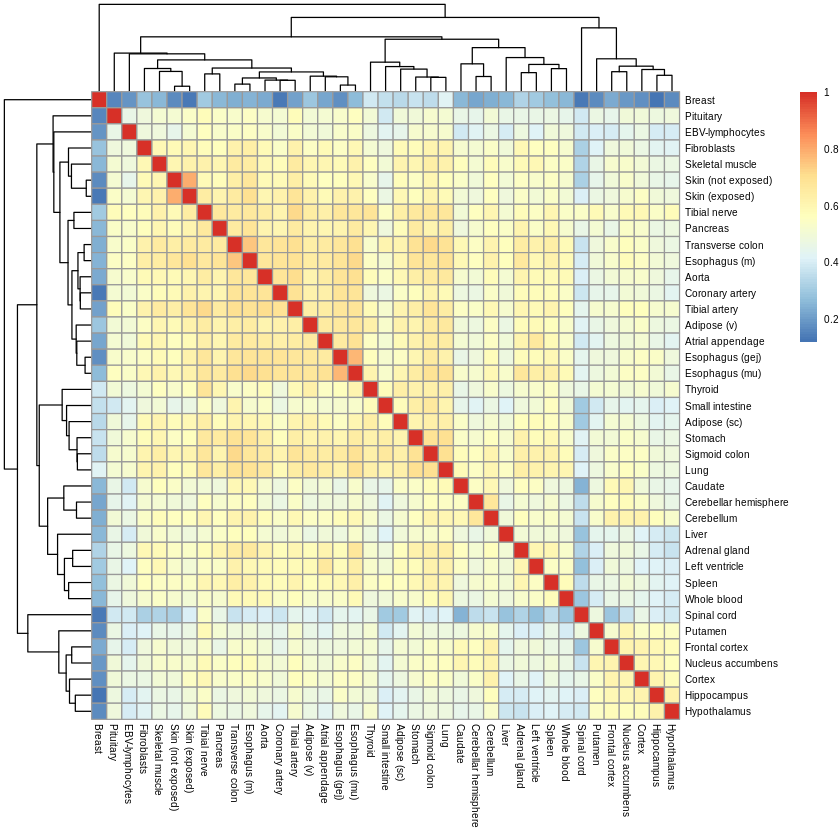

In [31]:
# dist_mat all values logFC_mat
dist_mat <- as.matrix(cor(logFC_mat))
pheatmap(as.matrix(dist_mat), clustering_distance_rows = "correlation", clustering_distance_cols = "correlation", fontsize = 6)
hm.parameters <- list(dist_mat, fontsize = 6)
do.call("pheatmap", c(hm.parameters,  filename="../pdf/FigureGenesHeatmapAlllogFC.pdf"))

# dist_mat all values with logFC_mat normalizeQuantiles 
logFC_mat_NQ <- normalizeQuantiles(logFC_mat)
dist_mat <- as.matrix(cor(logFC_mat_NQ))
pheatmap(as.matrix(dist_mat), clustering_distance_rows = "correlation", clustering_distance_cols = "correlation", fontsize = 6)
hm.parameters <- list(dist_mat, fontsize = 6)
do.call("pheatmap", c(hm.parameters,  filename="../pdf/FigureGenesHeatmapAlllogFC_NQ.pdf"))

# dist_mat all values with logFC_mat_gt_1.5 
dist_mat <- as.matrix(cor(logFC_gt_1.5))
pheatmap(as.matrix(dist_mat), clustering_distance_rows = "correlation", clustering_distance_cols = "correlation", fontsize = 6)
hm.parameters <- list(dist_mat, fontsize = 6)
do.call("pheatmap", c(hm.parameters,  filename="../pdf/FigureGenesHeatmapAlllogFC_gt_1.5.pdf"))

# dist_mat all values with logFC_gt_1.5_mat normalizeQuantiles 
logFC_mat_gt_1.5_NQ <- normalizeQuantiles(logFC_gt_1.5)
dist_mat <- as.matrix(cor(logFC_mat_gt_1.5_NQ))
pheatmap(as.matrix(dist_mat), clustering_distance_rows = "correlation", clustering_distance_cols = "correlation", fontsize = 6)
hm.parameters <- list(dist_mat, fontsize = 6)
do.call("pheatmap", c(hm.parameters,  filename="../pdf/FigureGenesHeatmapAlllogFC_gt_1.5NQ.pdf"))


In [32]:
rownames(dist_mat) <- colnames(logFC_mat_gt_1.5_NQ)
colnames(dist_mat) <- colnames(logFC_mat_gt_1.5_NQ)

message("Saving dist_mat object")
saveRDS(object = dist_mat, file = "../data/dist_mat.rds")
message("Done!")

Saving dist_mat object
Done!


## Generate panel 1c
A `heatplot` representing similarity in the fold-changes between male and female samples, 
with the values in the heatmap being the correlation between the vectors of fold changes of the tissues. </b>

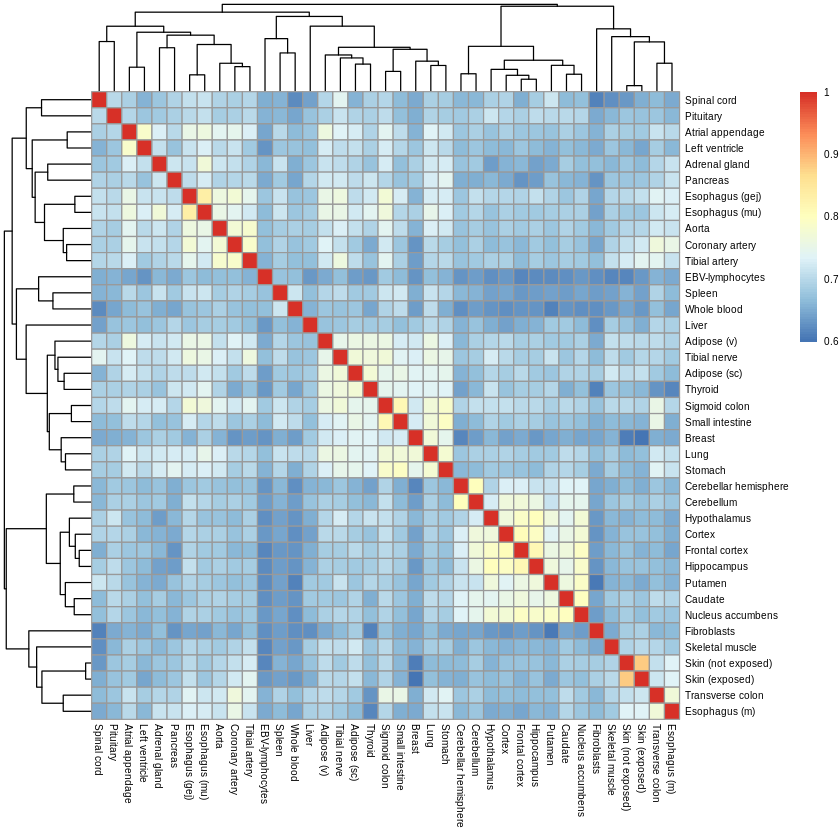

In [33]:
library(pheatmap)

pheatmap(as.matrix(dist_mat), clustering_distance_rows = "correlation", clustering_distance_cols = "correlation", fontsize = 6)
hm.parameters <- list(dist_mat, fontsize = 6)
do.call("pheatmap", c(hm.parameters,  filename="../pdf/Figure1c.pdf"))

# Figure 1e - Number of sex-biased AS events per tissue type.

In [34]:
rm(totals)
totals <- read.table("../data/Totals_by_tissue.tsv", sep = "\t", header = T)
totals$Label <- totals$tissue
for (i in (1:length(totals[,"Tissue"]))) {
    id <- as.character(tissue_reduction[,"SMTSD"]) %in% as.character(totals[i,"Tissue"])
    totals[i,"Label"] <- tissue_reduction[id,"display_name"]
    message("\nmatch to display name\n",
        paste(totals[i,"Label"], collapse = " "))

}
totals_s <- totals %>% arrange(Total)
totals_s$Label <- factor(totals_s$Label, levels = totals_s$Label)
levels(totals_s$Label)

Warning message in rm(totals):
“object 'totals' not found”
match to display name
Breast

match to display name
Nucleus accumbens

match to display name
Esophagus (mu)

match to display name
Aorta

match to display name
Fibroblasts

match to display name
Thyroid

match to display name
Pituitary

match to display name
Adipose (sc)

match to display name
Spleen

match to display name
Skeletal muscle

match to display name
Skin (exposed)

match to display name
Adrenal gland

match to display name
Adipose (v)

match to display name
Hippocampus

match to display name
EBV-lymphocytes

match to display name
Tibial artery

match to display name
Cerebellum

match to display name
Liver

match to display name
Esophagus (gej)

match to display name
Atrial appendage

match to display name
Esophagus (m)

match to display name
Pancreas

match to display name
Skin (not exposed)

match to display name
Cortex

match to display name
Spinal cord

match to display name
Lung

match to display name
Coronary a

[1] "Frontal cortex"        "Sigmoid colon"         "Cerebellar hemisphere"
 [4] "Putamen"               "Whole blood"           "Transverse colon"     
 [7] "Small intestine"       "Caudate"               "Hypothalamus"         
[10] "Left ventricle"        "Stomach"               "Tibial nerve"         
[13] "Coronary artery"       "Spinal cord"           "Lung"                 
[16] "Cortex"                "Esophagus (m)"         "Pancreas"             
[19] "Skin (not exposed)"    "Atrial appendage"      "Esophagus (gej)"      
[22] "Cerebellum"            "Liver"                 "Tibial artery"        
[25] "EBV-lymphocytes"       "Hippocampus"           "Adipose (v)"          
[28] "Adrenal gland"         "Skin (exposed)"        "Skeletal muscle"      
[31] "Adipose (sc)"          "Spleen"                "Pituitary"            
[34] "Thyroid"               "Fibroblasts"           "Aorta"                
[37] "Esophagus (mu)"        "Nucleus accumbens"     "Breast"

### Write the Totals_by_tissue as Totals_by_tissue_annotated.txt

The file Totals_by_tissue.tsv was missing the `Label` which here has now been added.
write this out and release it for others to use.

In [35]:
write.table(totals_s, file="../data/Totals_by_tissue_annotated.txt", quote=FALSE, sep = "\t")

In [36]:
## Function to get a reverse log10 scale on the x axis
reverselog_trans <- function(base = exp(1)) {
  trans <- function(x) -log(x, base)
  inv <- function(x) base^(-x)
  trans_new(paste0("reverselog-", format(base)), trans, inv, 
            log_breaks(base = base), 
            domain = c(1e-100, Inf))
}


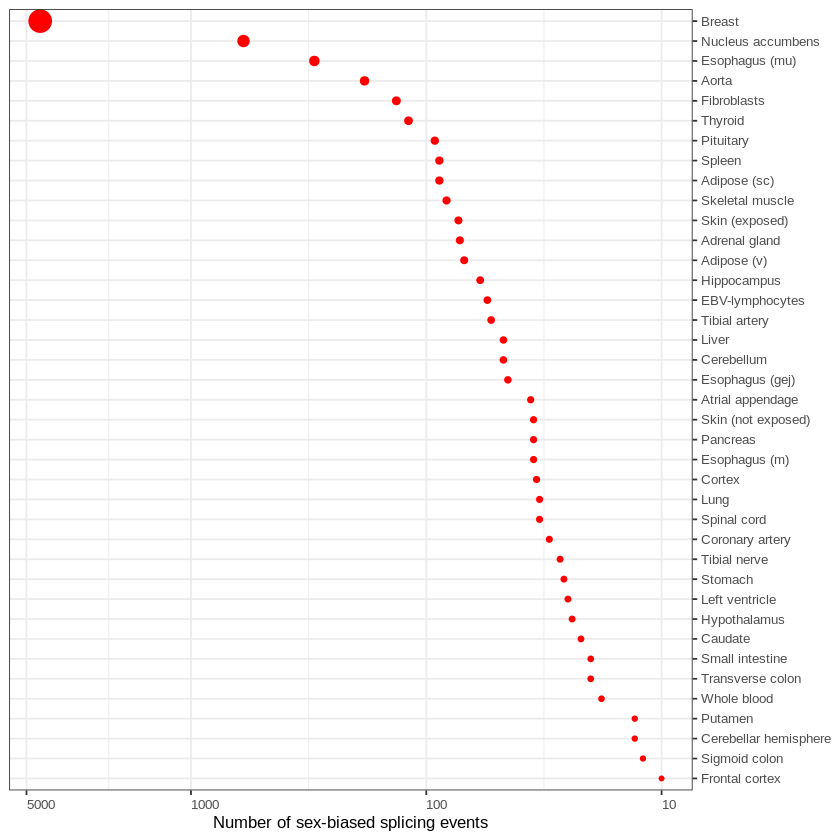

In [37]:
g<-ggplot(totals_s, aes(y = Label, x = Total, size = Total)) +
  geom_point(color = "red") +
  theme_bw() +
  scale_x_continuous(trans=reverselog_trans(), breaks=c(1,10,100,1000,5000,10000)) +#breaks=c(10000, 5000,1000,100,10,1)) +
  scale_y_discrete(position = "right") +
  theme(axis.text.x = element_text(size=8, angle = 0, hjust = 0.0, vjust = 0.5),
        axis.text.y = element_text(size=8),
        axis.title.x = element_text(face="plain", colour="black", 
                                    size=10),
        axis.title.y = element_blank(),
        legend.title=element_blank(),
        legend.text = element_text(face="plain", colour="black", 
                                   size=8)) +
  xlab(paste("Number of sex-biased splicing events")) +
  ylab("Tissue") + 
  guides(size=FALSE)

g
ggsave("../pdf/Figure1d.pdf",g, height = 4.5, width = 4)

# 5 Metadata

For replicability and reproducibility purposes, we also print the following metadata:

## 5.1. Checksums with the sha256 algorithm
1. Checksums of **'artefacts'**, files generated during the analysis and stored in the folder directory **`data`**
2. List of environment metadata, dependencies, versions of libraries using `utils::sessionInfo()` and [`devtools::session_info()`](https://devtools.r-lib.org/reference/session_info.html)

In [38]:
figure_id   = "figure1"

message("Generating sha256 checksums of the artefacts in the `..data/` directory .. ")
system(paste0("cd ../data && find . -type f -exec sha256sum {} \\;  >  ../metadata/", figure_id, "_sha256sums.txt"), intern = TRUE)
message("Done!\n")

data.table::fread(paste0("../metadata/", figure_id, "_sha256sums.txt"), header = FALSE, col.names = c("sha256sum", "file"))

Generating sha256 checksums of the artefacts in the `..data/` directory .. 


character(0)

Done!



sha256sum,file
<chr>,<chr>
a9f73d24aedaa5f79bf5ff4d1f8809aa0ee3843972614b8a0b8cb767a366ccec,./liver_DGE.csv
8cdd37a8d59fad600f71afa6990ecd1f53fe98a42ea30004ba48dcaf671fb72d,./se_brain_hypothalamus_sjc_sex_universe.txt
e3b0c44298fc1c149afbf4c8996fb92427ae41e4649b934ca495991b7852b855,./mxe_heart_left_ventricle_sex_as_events_gene_set.txt
bf4547760fb590dcb3e2fc283131757c1bdef03a546790a4323b66cd3d9d3021,./ri_esophagus_muscularis_sex_as_events_universe.txt
1d173f6d2b760e64965c458c6bd04a8cb0802b1f0b069cf5d90418aedebe72f7,./a5ss_thyroid_DGE_sex.csv
4eaab8f5ac7336054b4362a09c82f670317b842b9f5f352efcf49011b6a5d5c1,./a3ss_whole_blood_DGE_sex_as_events_refined.csv
9efbca6290f52a830d20b3b1e66cfba5178cab25fe5e7f0ab08b724eba48c6e6,./se_muscle_skeletal_sex_gene_set.txt
ce7cfd476dd881cf8997118dad34565685a9db56c24aa3896a840b054d5383e5,./a5ss_brain_spinal_cord_cervical_c_1_DGE_sjc_sex_refined.csv
784fc6ad657b4eddda9d28fb15cfcb35b5fb87bf315cddf0b9897a92d4c287a0,./a5ss_small_intestine_terminal_ileum_ijc_sex_universe.txt


## 5.2. Library metadata

In [39]:
dev_session_info   <- devtools::session_info()
utils_session_info <- utils::sessionInfo()

message("Saving `devtools::session_info()` objects in ../metadata/devtools_session_info.rds  ..")
saveRDS(dev_session_info, file = paste0("../metadata/", figure_id, "_devtools_session_info.rds"))
message("Done!\n")

message("Saving `utils::sessionInfo()` objects in ../metadata/utils_session_info.rds  ..")
saveRDS(utils_session_info, file = paste0("../metadata/", figure_id ,"_utils_info.rds"))
message("Done!\n")

dev_session_info$platform
dev_session_info$packages[dev_session_info$packages$attached==TRUE, ]

Saving `devtools::session_info()` objects in ../metadata/devtools_session_info.rds  ..
Done!

Saving `utils::sessionInfo()` objects in ../metadata/utils_session_info.rds  ..
Done!



 setting  value                       
 version  R version 3.6.1 (2019-07-05)
 os       Ubuntu 18.04.3 LTS          
 system   x86_64, linux-gnu           
 ui       X11                         
 language en_US.UTF-8                 
 collate  en_US.UTF-8                 
 ctype    en_US.UTF-8                 
 tz       Etc/UTC                     
 date     2020-05-28                  

,package,ondiskversion,loadedversion,path,loadedpath,attached,is_base,date,source,md5ok,library
,<chr>,<chr>,<chr>,<chr>,<chr>,<lgl>,<lgl>,<chr>,<chr>,<lgl>,<fct>
Biobase,Biobase,2.46.0,2.46.0,/opt/conda/lib/R/library/Biobase,/opt/conda/lib/R/library/Biobase,TRUE,FALSE,2019-10-29,Bioconductor,NA,/opt/conda/lib/R/library
BiocGenerics,BiocGenerics,0.32.0,0.32.0,/opt/conda/lib/R/library/BiocGenerics,/opt/conda/lib/R/library/BiocGenerics,TRUE,FALSE,2019-10-29,Bioconductor,NA,/opt/conda/lib/R/library
biomaRt,biomaRt,2.42.0,2.42.0,/opt/conda/lib/R/library/biomaRt,/opt/conda/lib/R/library/biomaRt,TRUE,FALSE,2019-10-29,Bioconductor,NA,/opt/conda/lib/R/library
DBI,DBI,1.1.0,1.1.0,/opt/conda/lib/R/library/DBI,/opt/conda/lib/R/library/DBI,TRUE,FALSE,2019-12-15,CRAN (R 3.6.3),NA,/opt/conda/lib/R/library
devtools,devtools,2.0.2,2.0.2,/opt/conda/lib/R/library/devtools,/opt/conda/lib/R/library/devtools,TRUE,FALSE,2019-04-08,CRAN (R 3.6.0),NA,/opt/conda/lib/R/library
downloader,downloader,0.4,0.4,/opt/conda/lib/R/library/downloader,/opt/conda/lib/R/library/downloader,TRUE,FALSE,2015-07-09,CRAN (R 3.6.3),NA,/opt/conda/lib/R/library
dplyr,dplyr,0.8.4,0.8.4,/opt/conda/lib/R/library/dplyr,/opt/conda/lib/R/library/dplyr,TRUE,FALSE,2020-01-31,CRAN (R 3.6.2),NA,/opt/conda/lib/R/library
edgeR,edgeR,3.28.1,3.28.1,/opt/conda/lib/R/library/edgeR,/opt/conda/lib/R/library/edgeR,TRUE,FALSE,2020-02-26,Bioconductor,NA,/opt/conda/lib/R/library
ggplot2,ggplot2,3.2.1,3.2.1,/opt/conda/lib/R/library/ggplot2,/opt/conda/lib/R/library/ggplot2,TRUE,FALSE,2019-08-10,CRAN (R 3.6.1),NA,/opt/conda/lib/R/library
